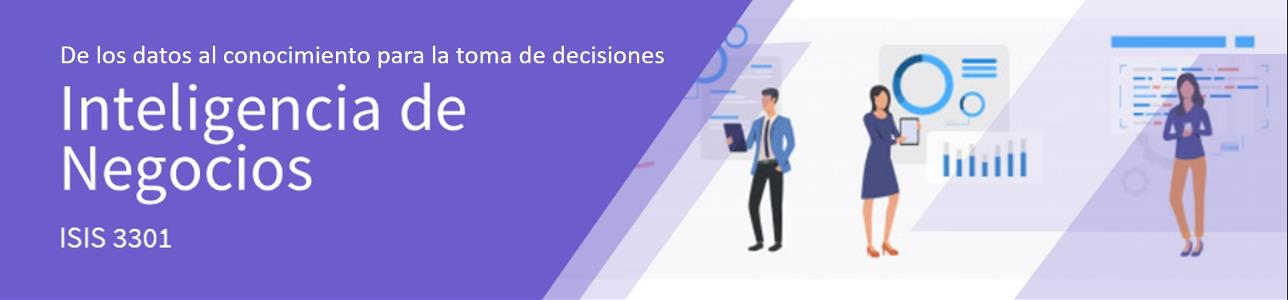

# Tema
<p style="text-align: justify;"> Predicción de emociones acorde a comentarios o posts en redes sociales En la actualidad todos se encuentran en las redes sociales y las personas no son timidas al comentar o publicar su opinion por lo que estas son una fuente de informacion ilimitada de las opiniones de los usuarios,  ademas dado que el contenido es solo escrito las palabras usadas hacen mucho enfasis en sus emociones al momento de publicarlo, por lo tanto seria posible entrenar un modelo de clasificacion que permita determinar que emocion o emociones tenia el usuario en ese momento

Interes Negocio:
Si se filtran por publicaciones referentes a cierto comercio o cierto sector de negocios es posible hacerse a una idea de como se encuentra la opinion publica al respecto, lo cual puede ser significativamente util

# 1. Instalación e importanción de librerías.


In [1]:
# Librería para manejar las contracciones que se presentan en el inglés.
!pip install contractions

In [2]:
# librería Natural Language Toolkit, usada para trabajar con textos 
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Instalación de librerias
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy import stats as st
import sys
from pandas_profiling import ProfileReport
import re, unicodedata
import contractions
import inflect
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve
import matplotlib.pyplot as plt


# 2. Perfilamiento y entendimiento de los datos



## Lectura de los datos.

In [4]:
# Uso de la libreria pandas para la lectura de archivos
dtypes={'text':str, 'feeling':'category'}
test=pd.read_csv('test.txt', sep=';', dtype=dtypes, header=None, names=['text','feeling'])
train=pd.read_csv('train.txt', sep=';', dtype=dtypes, header=None, names=['text','feeling'])

In [5]:
# Convertir text de object a string
test=test.convert_dtypes()
train=train.convert_dtypes()

In [6]:
# Copia de los datos
data_r= train
data_t=test

## Entendimiento de los Datos

Para entender los mensajes, se realizan 'estadísticas descriptivas' para poder obtener un análisis de los textos.


In [7]:
# Info de los datos
test.info()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   text     2000 non-null   string  
 1   feeling  2000 non-null   category
dtypes: category(1), string(1)
memory usage: 17.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15999 entries, 0 to 15998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   text     15999 non-null  string  
 1   feeling  15999 non-null  category
dtypes: category(1), string(1)
memory usage: 141.0 KB


In [8]:
textos = data_r.copy()
textos['Conteo'] = [len(x) for x in textos['text']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['text']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['text']]

# Se realiza un perfilamiento de los datos con la librería pandas profiling
ProfileReport(textos)

Summarize dataset: 19it [00:09,  2.06it/s, Completed]
Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


# 3. Preparación de datos

## **3.1 Limpieza de los datos**
Para eliminar caracteres no ascii, signos de puntuacion, numeros y pasar todo a minúscula.

In [9]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = str(word).lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words(['english']):
            new_words.append(word)
    return new_words

def preprocessing(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    return words

## **3.2 Tokenización**
La tokenización permite dividir frases u oraciones en palabras. Con el fin de desglozar las palabras correctamente para el posterior análisis. Pero primero, se realiza una corrección de las contracciones que pueden estar presentes en los textos. 

In [10]:
#Aplica la corrección de las contracciones
data_t['text'] = data_t['text'].apply(contractions.fix)
data_r['text'] = data_r['text'].apply(contractions.fix)

In [11]:
data_r['words'] = data_r.apply(lambda row: word_tokenize(row['text']), axis=1)
data_t['words'] = data_t.apply(lambda row: word_tokenize(row['text']), axis=1)

In [12]:
 #Aplica la eliminación del ruido
data_t['words'] = data_t['words'].apply(preprocessing)
data_r['words'] = data_r['words'].apply(preprocessing)

## **3.3. Normalización**
En la normalización de los datos se realiza la eliminación de prefijos y sufijos, además de realizar una lemmatización.

In [13]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

In [14]:
#Aplica lematización y Eliminación de Prefijos y Sufijos.
data_t['words'] = data_t['words'].apply(stem_and_lemmatize)
data_r['words'] = data_r['words'].apply(stem_and_lemmatize)
data_t.head()

,text,feeling,words
0,I am feeling rather rotten so I am not very am...,sadness,"[feel, rath, rot, amb, right, feel, rather, ro..."
1,I am updating my blog because i feel shitty,sadness,"[upd, blog, feel, shitty, update, blog, feel, ..."
2,i never make her separate from me because i do...,sadness,"[nev, mak, sep, ev, want, feel, lik, asham, ne..."
3,i left with my bouquet of red and yellow tulip...,joy,"[left, bouquet, red, yellow, tulip, arm, feel,..."
4,i was feeling a little vain when i did this one,sadness,"[feel, littl, vain, on, feel, little, vain, one]"


## **3.4 Selección de campos**

Primero, se separa la variable predictora y los textos que se van a utilizar.

In [15]:
data_r['words'] = data_r['words'].apply(lambda x: ' '.join(map(str, x)))
data_r

,text,feeling,words
0,i did not feel humiliated,sadness,feel humy feel humiliate
1,i can go from feeling so hopeless to so damned...,sadness,go feel hopeless damn hop around someon car aw...
2,I am grabbing a minute to post i feel greedy w...,anger,grab minut post feel greedy wrong grab minute ...
3,i am ever feeling nostalgic about the fireplac...,love,ev feel nostalg fireplac know stil property ev...
4,i am feeling grouchy,anger,feel grouchy feel grouchy
...,...,...,...
15994,i just had a very brief time in the beanbag an...,sadness,brief tim beanb said ann feel lik beat brief t...
15995,i am now turning and i feel pathetic that i am...,sadness,turn feel pathet stil wait tabl sub teach degr...
15996,i feel strong and good overall,joy,feel strong good overal feel strong good overall
15997,i feel like this was such a rude comment and I...,anger,feel lik rud com glad feel like rude comment glad


In [16]:
X_data, y_data = data_r['words'],data_r['feeling']
X_test, y_test = data_t['words'],data_t['feeling']
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)

# 4. Modelamiento y resultados

## **4.1 MultinomialNB**

Primero se realiza la generacion de vectores con tf-idf y, despues, se hace el multinomial naive bayes.

In [64]:
parameters = {'tfidf__use_idf': (True, False), 'tfidf__norm': ['l1', 'l2'], 'clf__alpha': (1e-2, 1e-3), 'clf__fit_prior': (False,True)}

text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=particiones)
gs_clf = gs_clf.fit(X_data, y_data)

y_predicted_multinomialNB = gs_clf.predict(y_test)

In [65]:
confusion_matrix(y_test, y_predicted_multinomialNB)
#plt.show()

array([[275,   0,   0,   0,   0,   0],
       [  0, 224,   0,   0,   0,   0],
       [  0,   0, 695,   0,   0,   0],
       [  0,   0,   0, 159,   0,   0],
       [581,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  66]], dtype=int64)

In [66]:
print(classification_report(y_test, y_predicted_multinomialNB))

              precision    recall  f1-score   support

       anger       0.32      1.00      0.49       275
        fear       1.00      1.00      1.00       224
         joy       1.00      1.00      1.00       695
        love       1.00      1.00      1.00       159
     sadness       0.00      0.00      0.00       581
    surprise       1.00      1.00      1.00        66

    accuracy                           0.71      2000
   macro avg       0.72      0.83      0.75      2000
weighted avg       0.62      0.71      0.64      2000



## **4.2 SVM**

In [55]:
parameters_svm = {'tfidf__use_idf': (True, False), 'tfidf__norm': ['l1', 'l2'], 'clf-svm__alpha': (1e-2, 1e-3),'clf-svm__penalty':['l1','l2','elasticnet']}

text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf-svm', SGDClassifier(loss='hinge', alpha=1e-3, max_iter=10, random_state=0))])

gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1, cv=particiones)
gs_clf_svm = gs_clf_svm.fit(X_data, y_data)

y_predicted_SVM = gs_clf_svm.predict(y_test)

In [56]:
confusion_matrix(y_test, y_predicted_SVM)
#plt.show()

array([[275,   0,   0,   0,   0,   0],
       [  0, 224,   0,   0,   0,   0],
       [  0,   0, 695,   0,   0,   0],
       [  0,   0, 159,   0,   0,   0],
       [581,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  66]], dtype=int64)

In [57]:
print(classification_report(y_test, y_predicted_SVM))

              precision    recall  f1-score   support

       anger       0.32      1.00      0.49       275
        fear       1.00      1.00      1.00       224
         joy       0.81      1.00      0.90       695
        love       0.00      0.00      0.00       159
     sadness       0.00      0.00      0.00       581
    surprise       1.00      1.00      1.00        66

    accuracy                           0.63      2000
   macro avg       0.52      0.67      0.56      2000
weighted avg       0.47      0.63      0.52      2000



## **4.3 Passive Agressive Classifier**


In [58]:
parameters_pac = {'tfidf__use_idf': (True, False), 'tfidf__norm': ['l1', 'l2'], 'tfidf__use_idf': (True, False), 'pac__fit_intercept':(True, False),'pac__n_iter_no_change':[5,8,10,13,18]}

text_pac = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('pac', PassiveAggressiveClassifier(random_state=8))])

gs_pac = GridSearchCV(text_pac, parameters_pac, n_jobs=-1, cv=particiones)
gs_pac = gs_pac.fit(X_data, y_data)

y_predicted_pac = gs_pac.predict(y_test)

In [59]:
confusion_matrix(y_test, y_predicted_pac)
#plt.show()

array([[275,   0,   0,   0,   0,   0],
       [  0, 224,   0,   0,   0,   0],
       [  0,   0, 695,   0,   0,   0],
       [  0,   0, 159,   0,   0,   0],
       [581,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  66]], dtype=int64)

In [60]:
print(classification_report(y_test, y_predicted_pac))

              precision    recall  f1-score   support

       anger       0.32      1.00      0.49       275
        fear       1.00      1.00      1.00       224
         joy       0.81      1.00      0.90       695
        love       0.00      0.00      0.00       159
     sadness       0.00      0.00      0.00       581
    surprise       1.00      1.00      1.00        66

    accuracy                           0.63      2000
   macro avg       0.52      0.67      0.56      2000
weighted avg       0.47      0.63      0.52      2000



## Mejor modelo
Una vez ejecutados los tres modelos vemos que el mejor modelo es el de MultinomialNB, por lo que observamos los mejores hiperparametros encontrados por GridSearch

In [72]:
print('Best params:', gs_clf.best_params_)

Best params: {'clf__alpha': 0.01, 'clf__fit_prior': False, 'tfidf__norm': 'l1', 'tfidf__use_idf': False}


In [80]:
#añadimos la columna de predicción obtenida con el modelo a los datos de test
data_t['prediction'] = y_predicted_multinomialNB.tolist()
data_t

,text,feeling,words,prediction
0,I am feeling rather rotten so I am not very am...,sadness,"[feel, rath, rot, amb, right, feel, rather, ro...",anger
1,I am updating my blog because i feel shitty,sadness,"[upd, blog, feel, shitty, update, blog, feel, ...",anger
2,i never make her separate from me because i do...,sadness,"[nev, mak, sep, ev, want, feel, lik, asham, ne...",anger
3,i left with my bouquet of red and yellow tulip...,joy,"[left, bouquet, red, yellow, tulip, arm, feel,...",joy
4,i was feeling a little vain when i did this one,sadness,"[feel, littl, vain, on, feel, little, vain, one]",anger
...,...,...,...,...
1995,i just keep feeling like someone is being unki...,anger,"[keep, feel, lik, someon, unkind, wrong, think...",anger
1996,I am feeling a little cranky negative after th...,anger,"[feel, littl, cranky, neg, doct, appoint, feel...",anger
1997,i feel that i am useful to my people and that ...,joy,"[feel, us, peopl, giv, gre, feel, achiev, feel...",joy
1998,I am feeling more comfortable with derby i fee...,joy,"[feel, comfort, derby, feel, though, start, st...",joy


In [81]:
#Exportamos los datos test a un csv para poder hacer el dashboard
data_t.to_csv('final_data.csv')